# 1) Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import silhouette_visualizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

warnings.filterwarnings("ignore")
sns.set_style("white")

# 2) Coleta dos Dados

In [2]:
df = pd.read_csv(r'../Dados/Tabela_final/tabela_final.csv')
df

,IBGE7,UF,NOME,LATITUDE,LONGITUDE,DIST_EF_PUB,DIST_EM_PUB,IDEB_AI,IDEB_AF,DOCSUP_EF_PUB,...,T_ANALF15M,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,RDPC,QUAL_MED_AGUA,TRANSPORT_COST,TOT_ESC_POR_POP,TOT_MAT_POR_POP
0,2700300,AL,ARAPIRACA,-9.75487,-36.6615,28.884,43.100,4.580,3.624,54.40,...,22.45,6.27,24.10,11.76,28.61,423.28,62.268456,24042.166072,0.000433,0.245423
1,2700706,AL,BATALHA,-9.67420,-37.1330,31.100,35.892,4.544,3.632,12.62,...,30.84,8.85,33.44,20.53,40.54,265.62,66.758485,24257.110578,0.001200,0.384829
2,2700904,AL,BELO MONTE,-9.82272,-37.2770,36.412,54.792,3.928,3.044,27.12,...,38.11,12.42,41.81,30.29,49.99,187.77,66.758485,24226.863743,0.002235,0.298063
3,2701209,AL,CACIMBINHAS,-9.40121,-36.9911,38.284,40.720,4.164,3.324,49.04,...,40.61,13.56,43.81,30.14,51.12,259.72,66.758485,24358.206538,0.001102,0.419781
4,2701605,AL,CANAPI,-9.11932,-37.5967,31.024,38.636,4.584,3.580,20.84,...,40.35,15.27,44.16,28.31,51.97,183.83,71.338777,24734.221802,0.002032,0.366838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2806008,SE,RIBEIROPOLIS,-10.53570,-37.4380,35.080,41.796,4.032,3.472,64.68,...,28.50,6.08,30.60,11.60,36.26,357.17,63.883423,23891.778664,0.000692,0.211261
1257,2807006,SE,SAO MIGUEL DO ALEIXO,-10.38470,-37.3836,33.148,47.912,3.940,3.116,62.08,...,33.54,7.79,37.03,18.32,44.72,279.25,63.883423,23954.902605,0.002280,0.196098
1258,2807105,SE,SIMAO DIAS,-10.73870,-37.8097,38.340,45.756,4.200,3.364,61.38,...,26.78,7.36,28.90,14.39,34.16,293.99,63.883423,23918.838452,0.001108,0.254938
1259,2807303,SE,TELHA,-10.20640,-36.8818,31.636,47.600,4.384,3.520,45.66,...,27.33,5.38,29.62,14.00,35.41,268.17,66.862432,23869.921712,0.001539,0.222838


# 2) Análise Exploratória

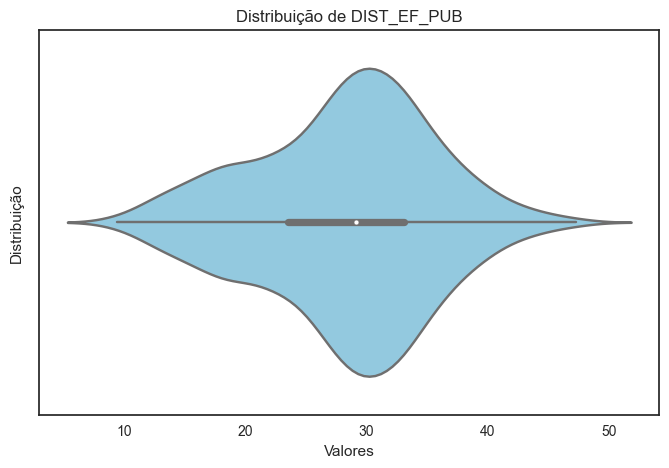

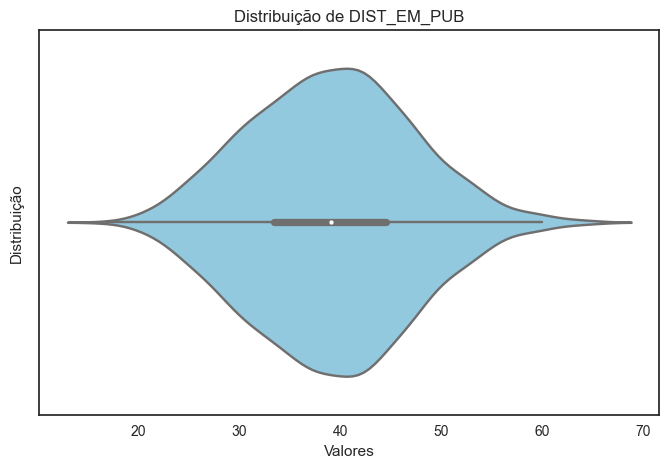

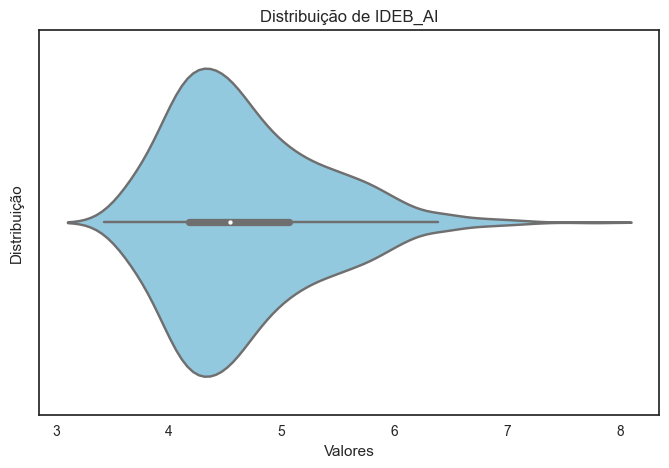

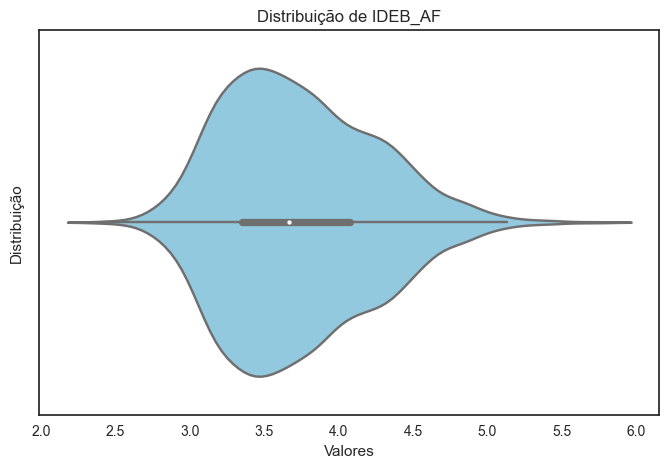

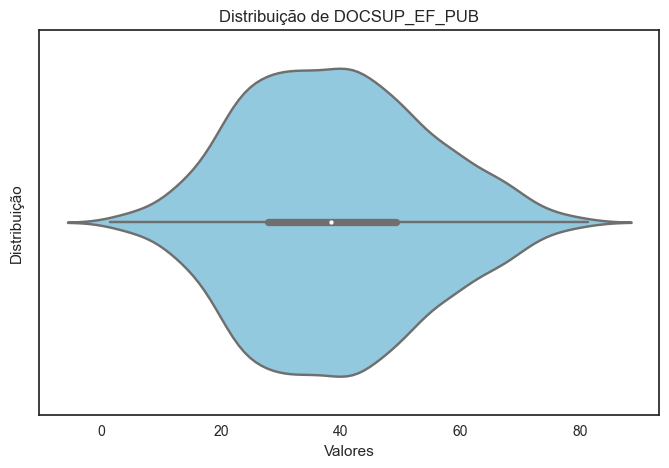

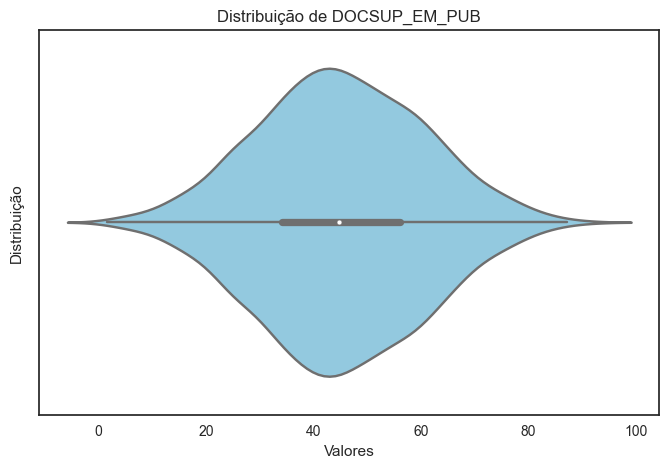

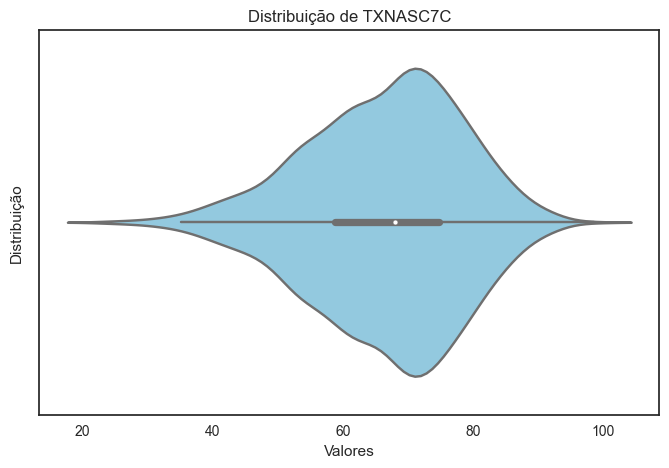

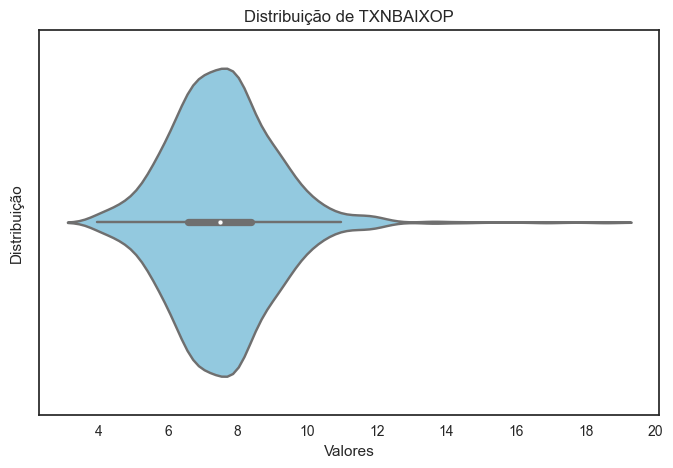

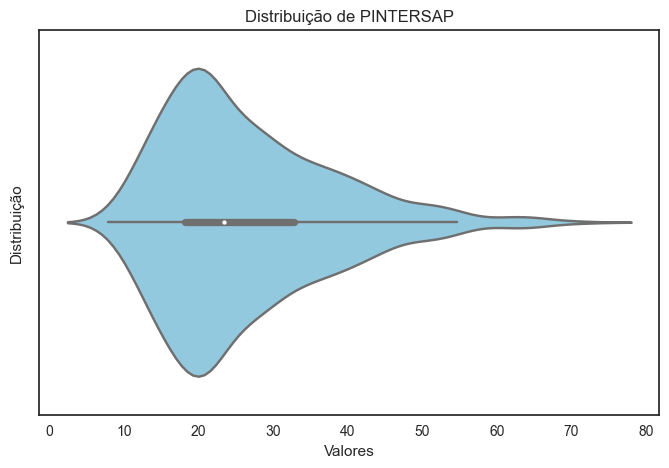

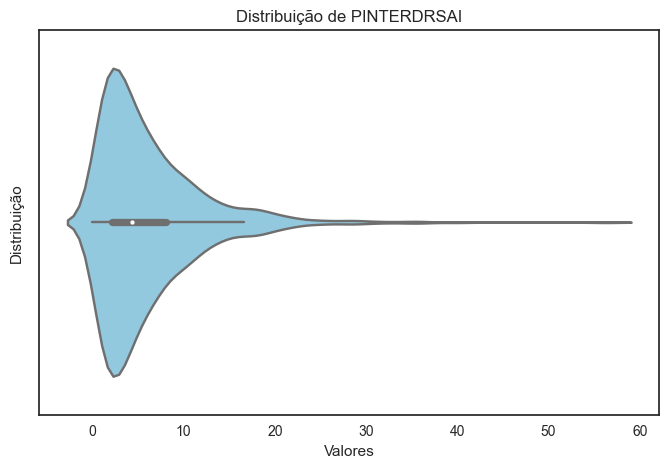

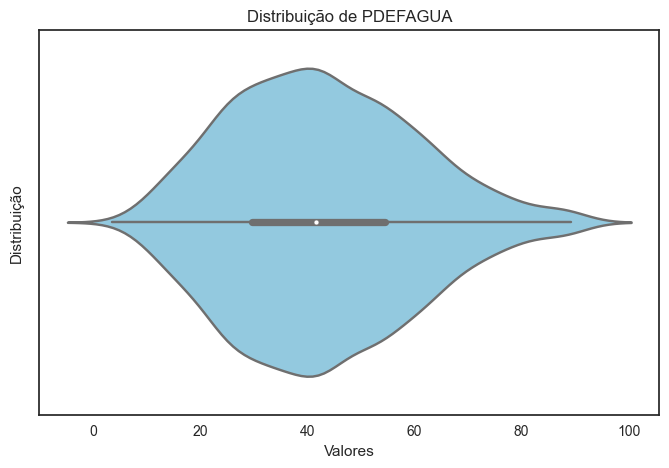

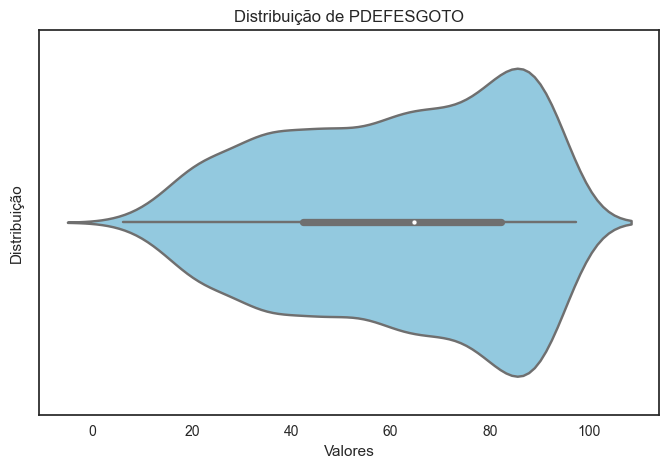

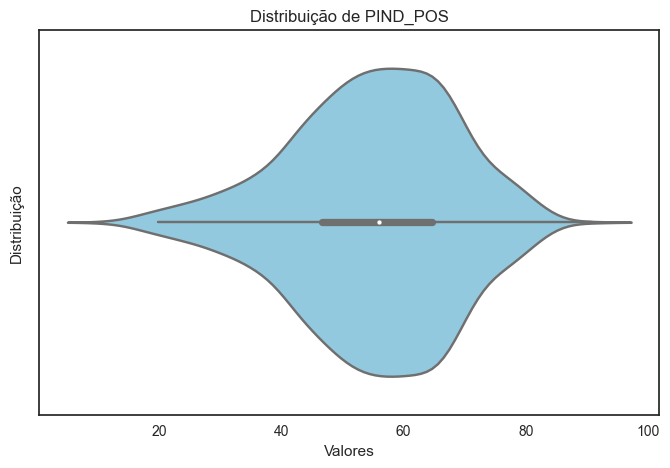

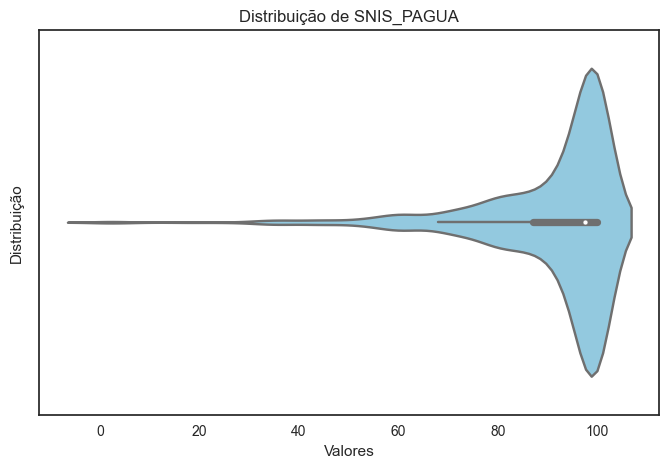

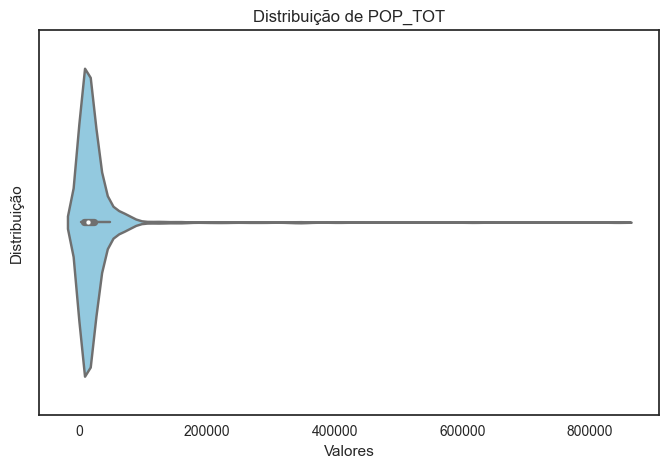

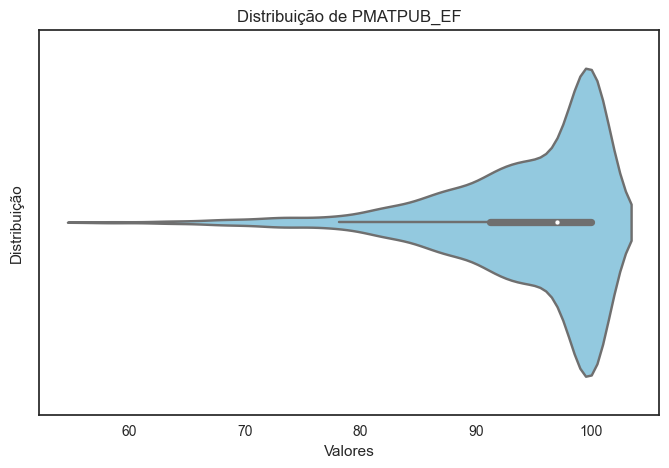

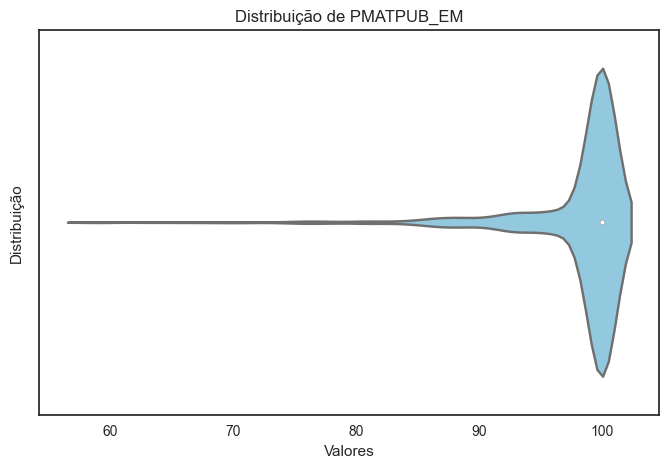

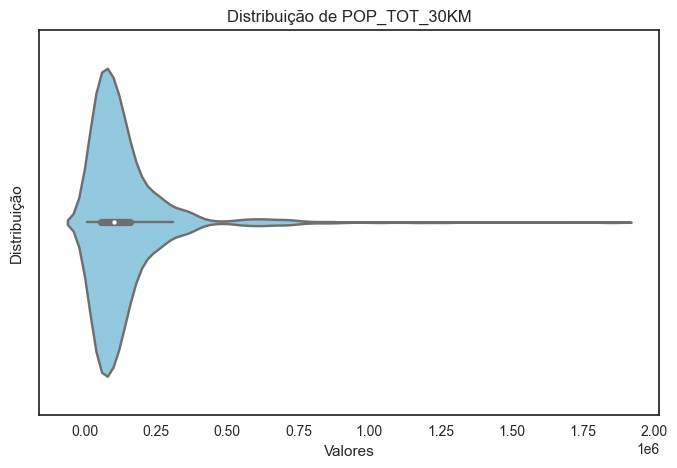

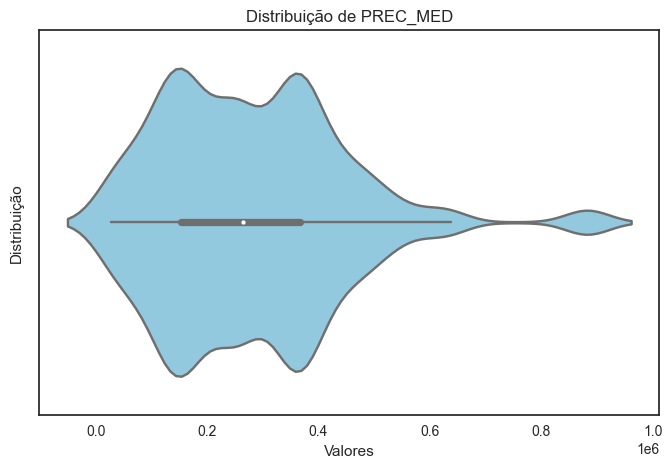

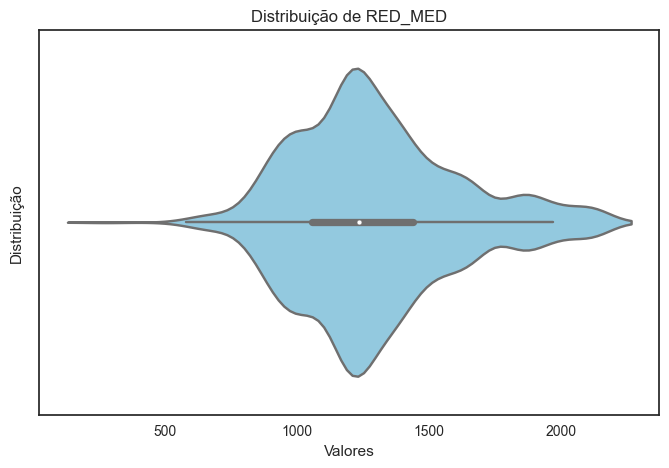

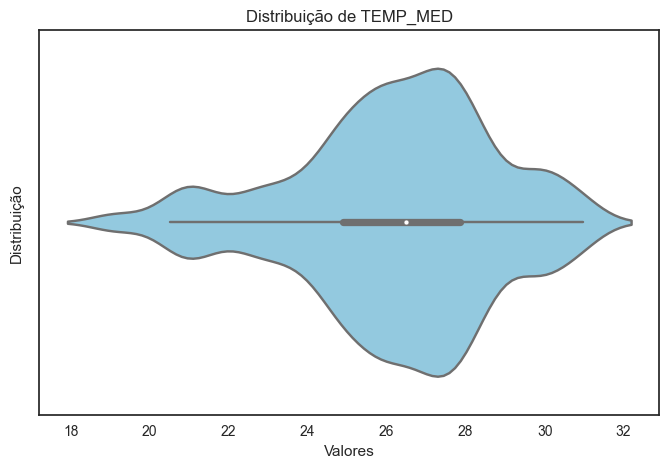

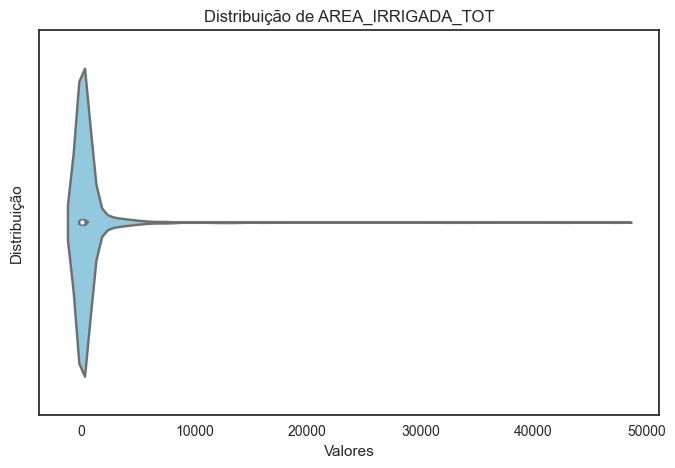

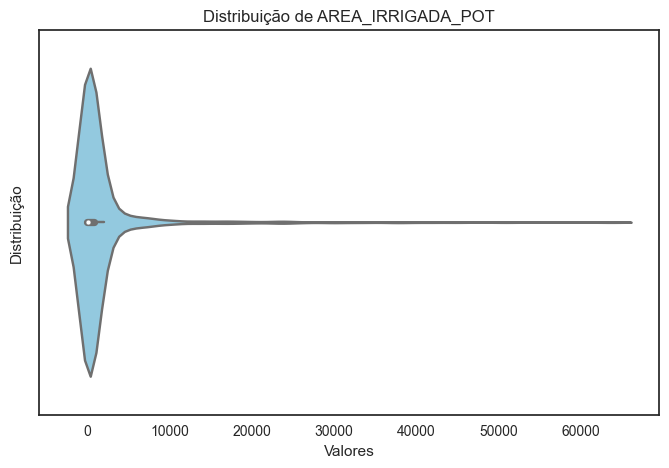

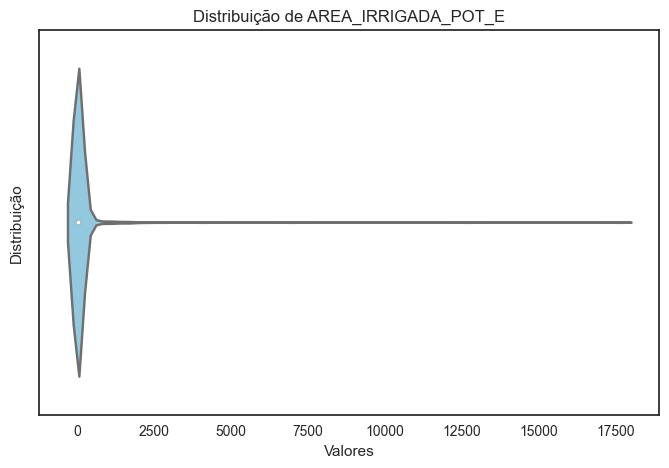

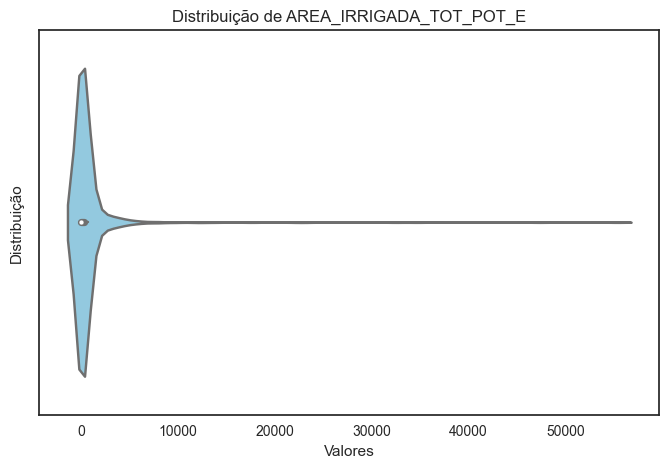

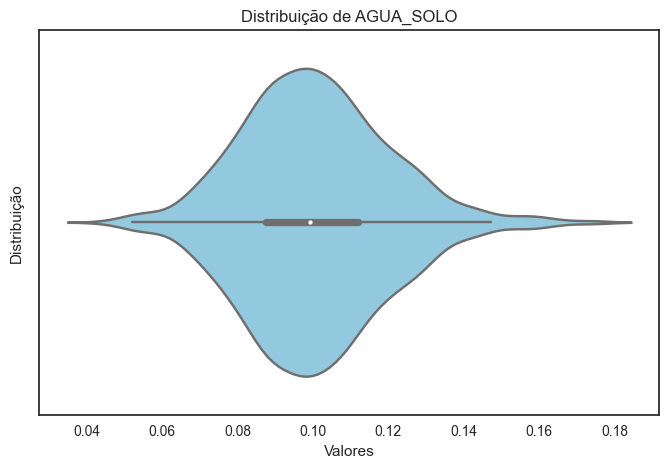

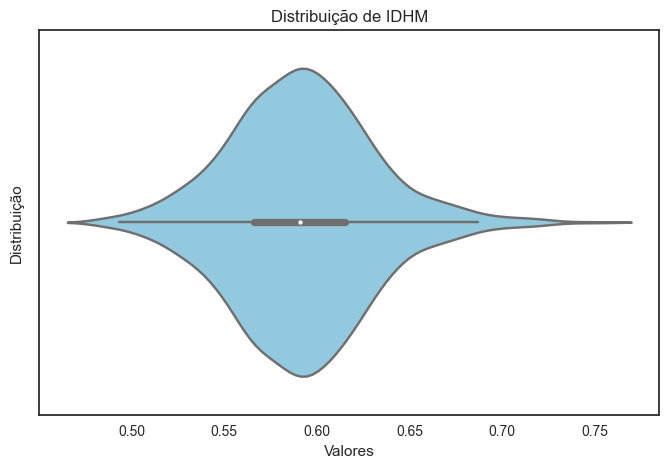

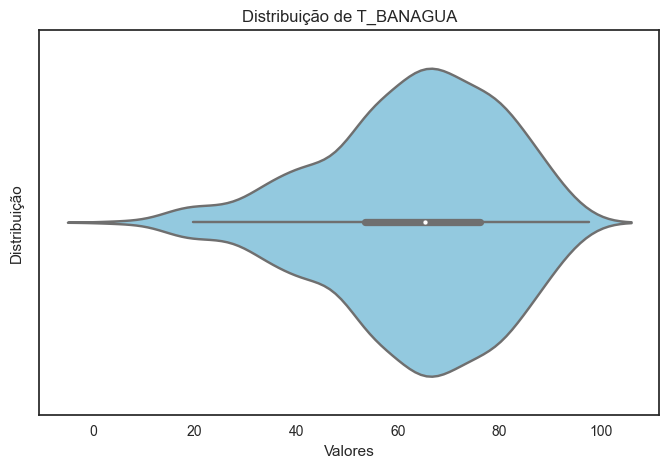

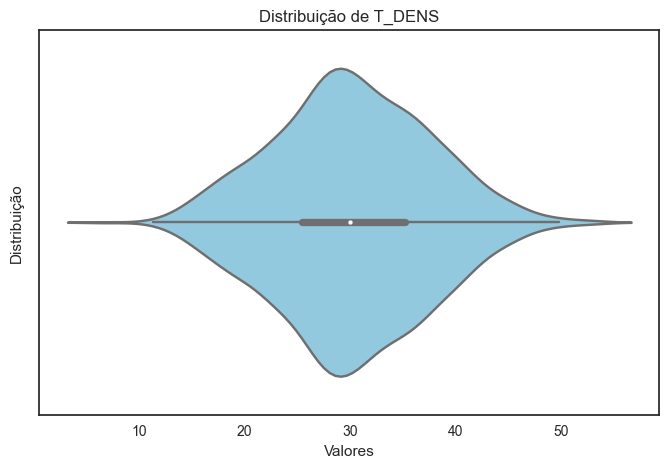

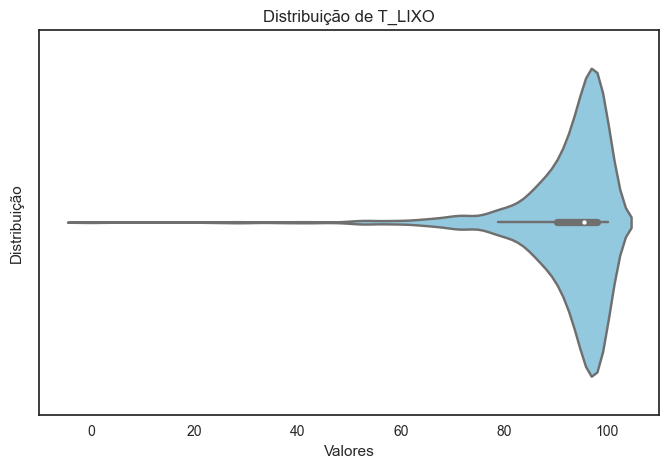

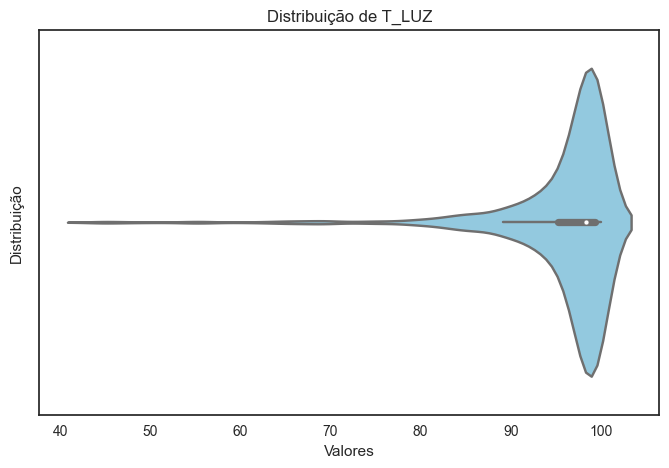

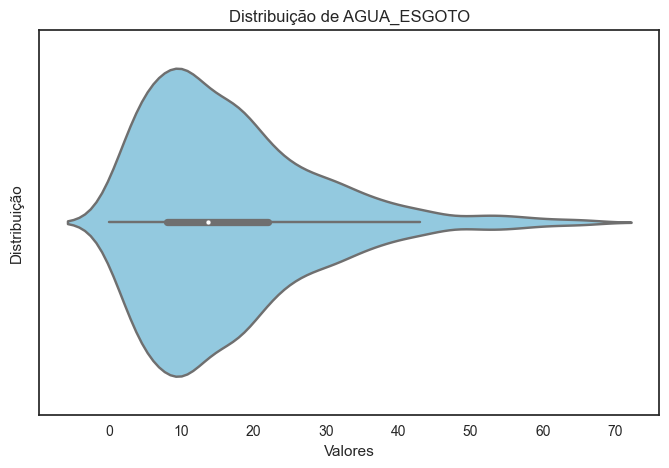

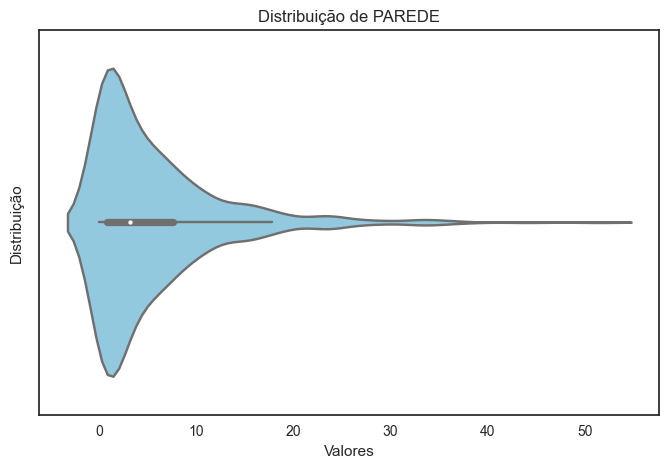

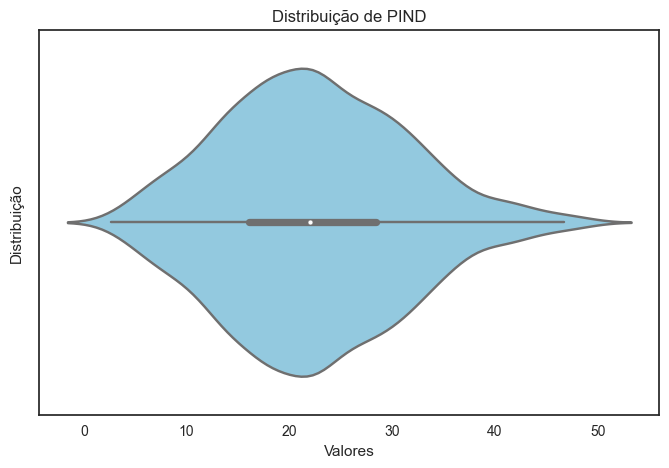

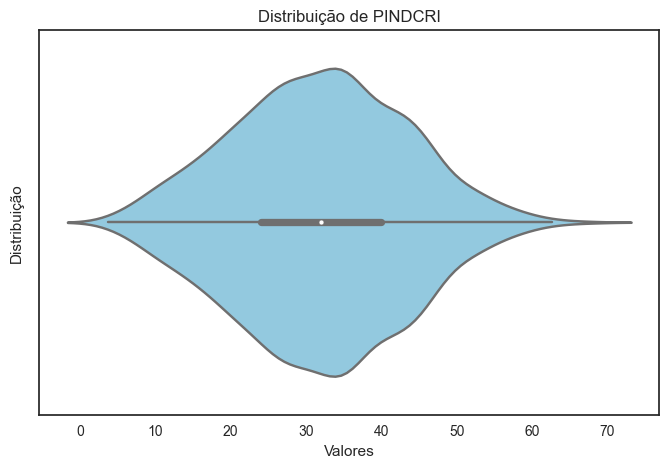

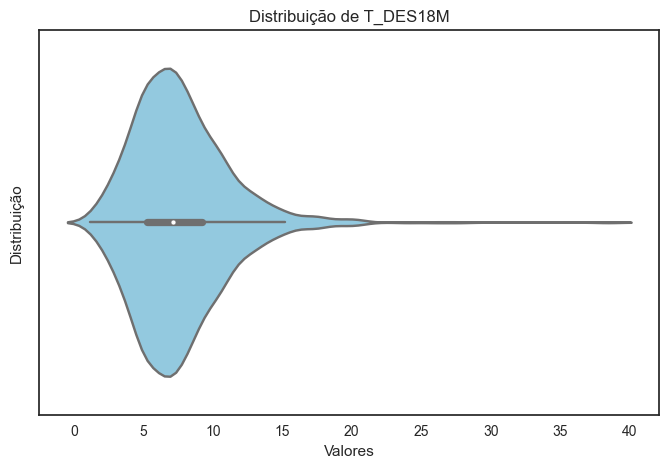

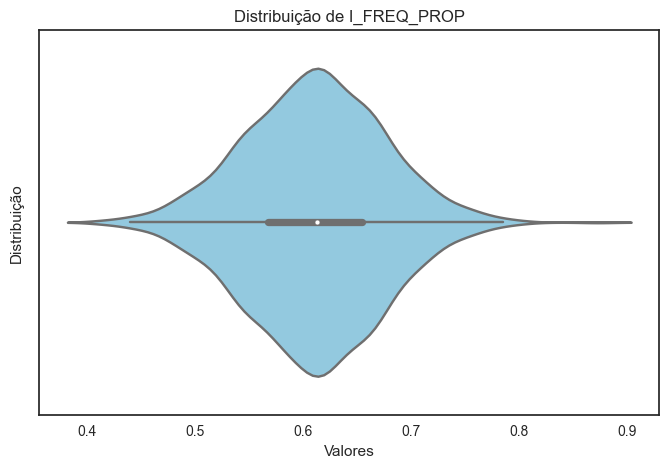

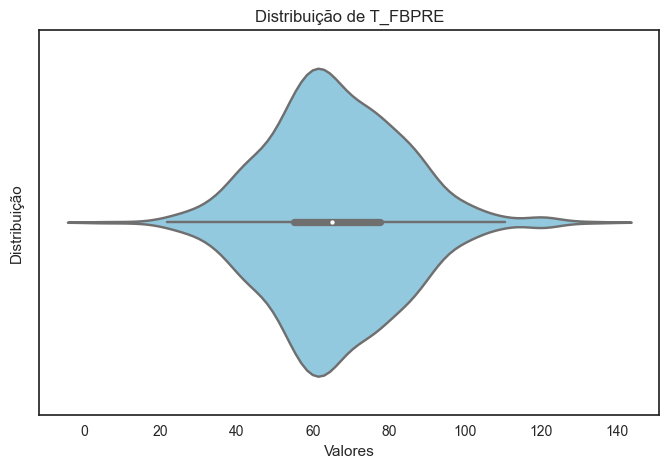

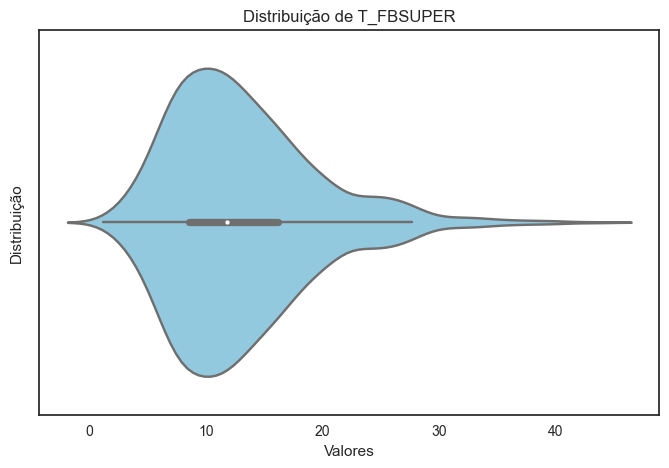

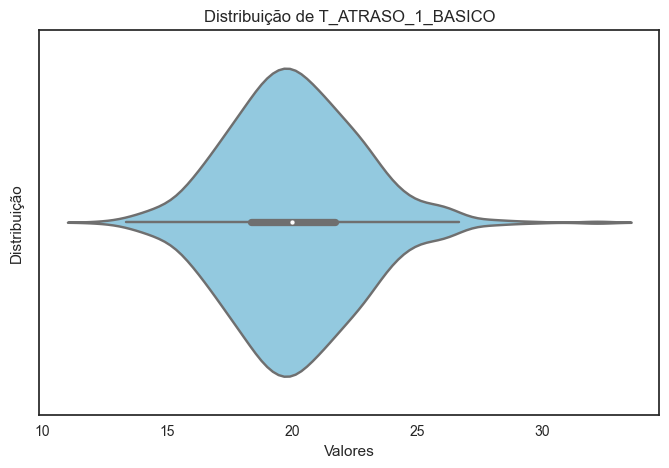

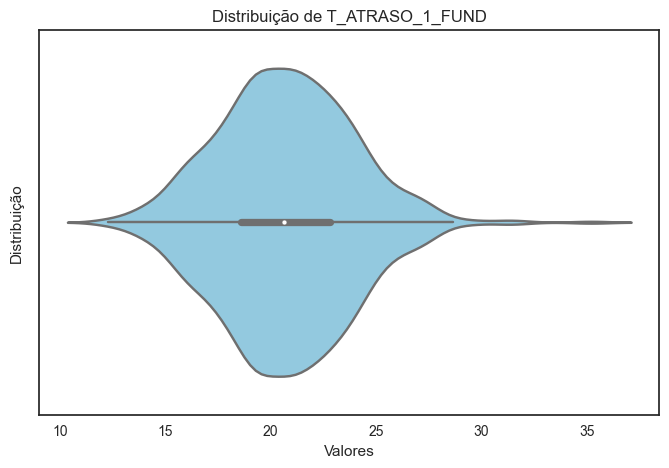

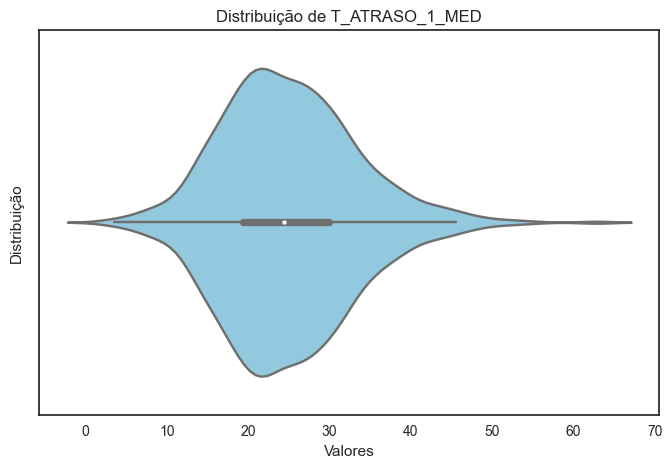

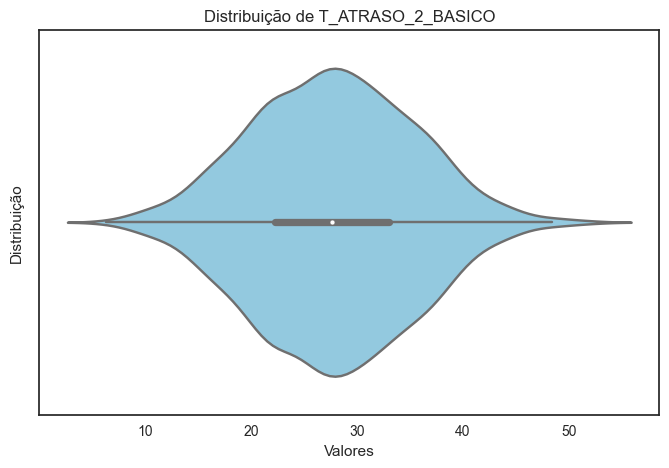

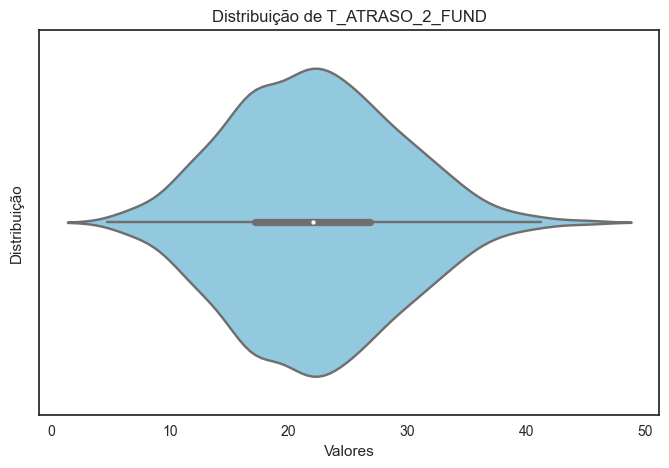

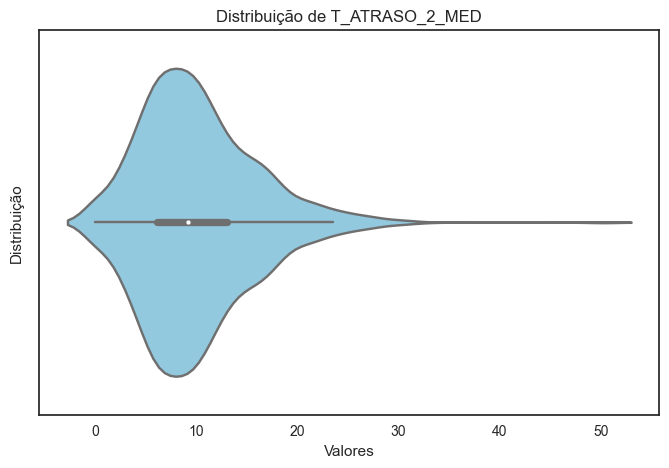

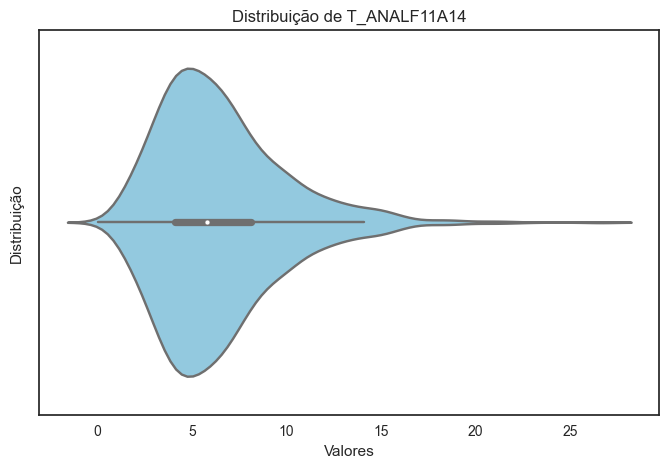

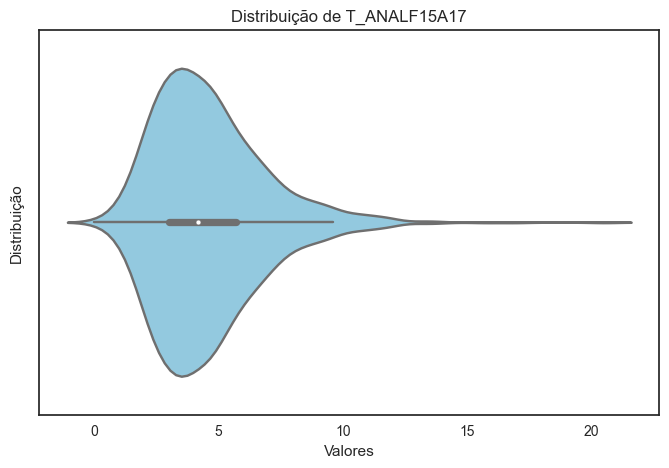

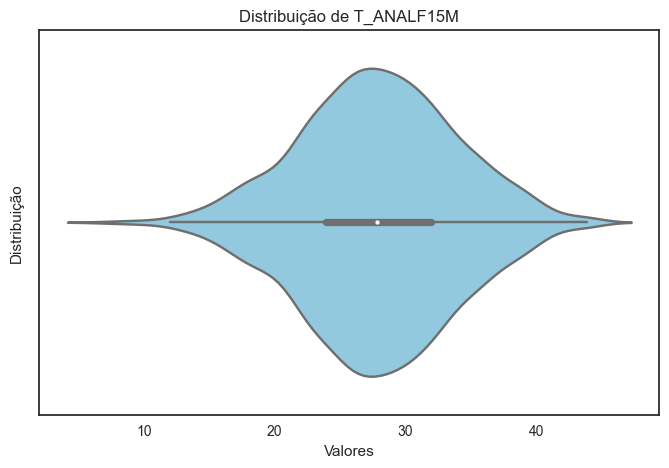

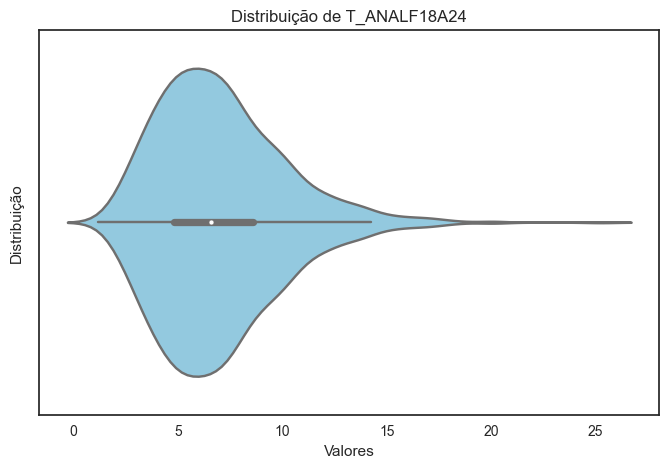

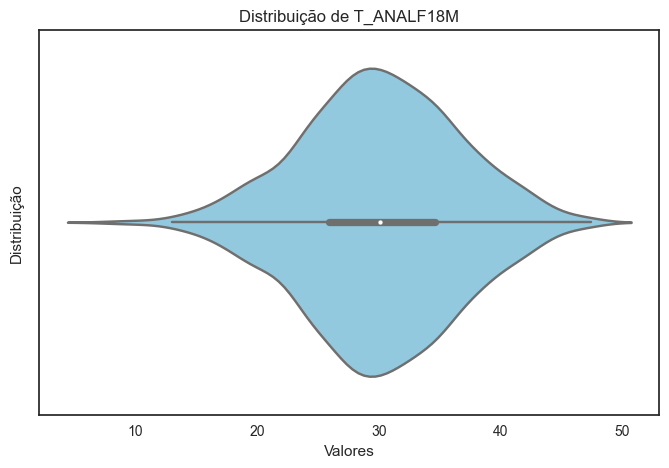

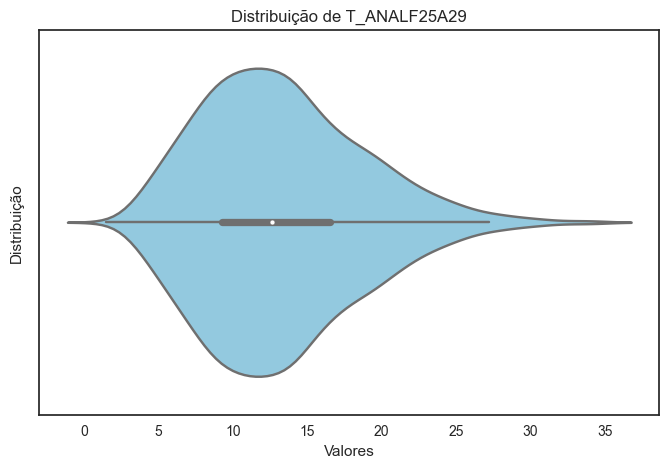

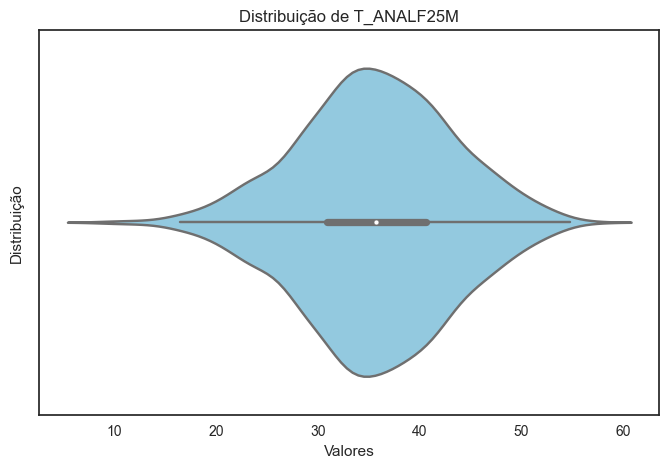

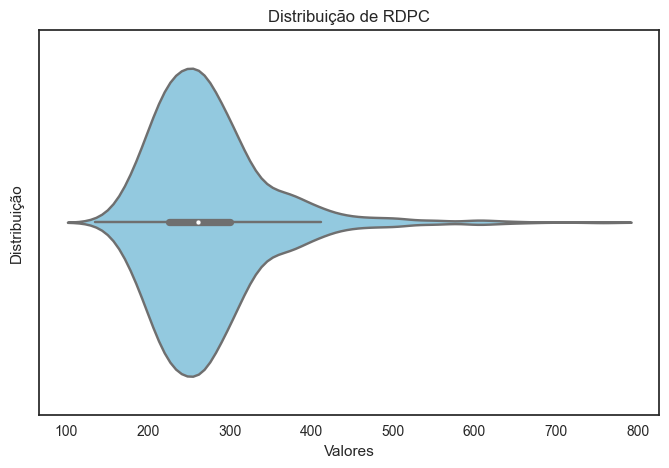

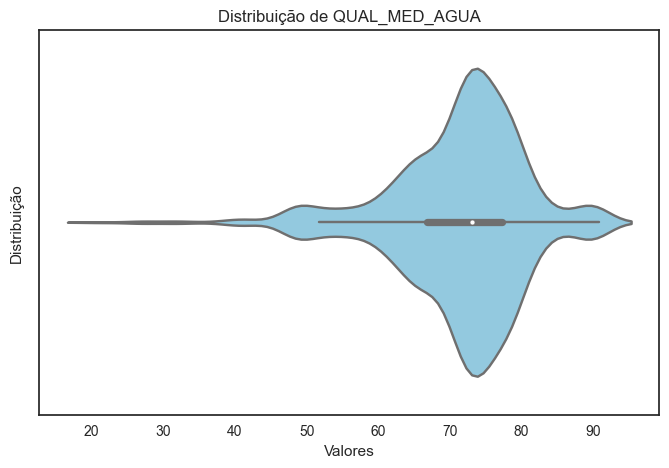

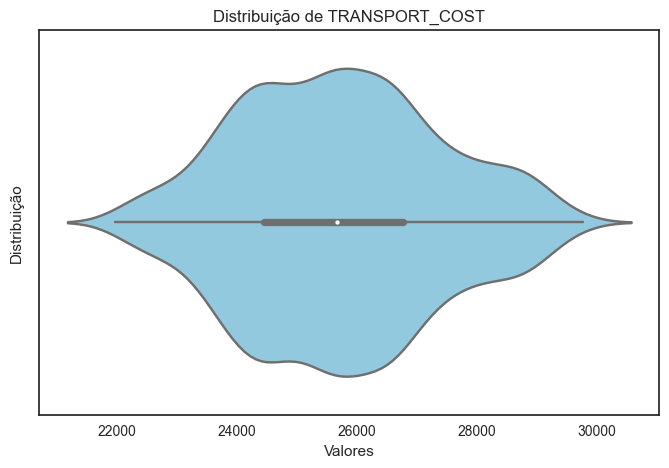

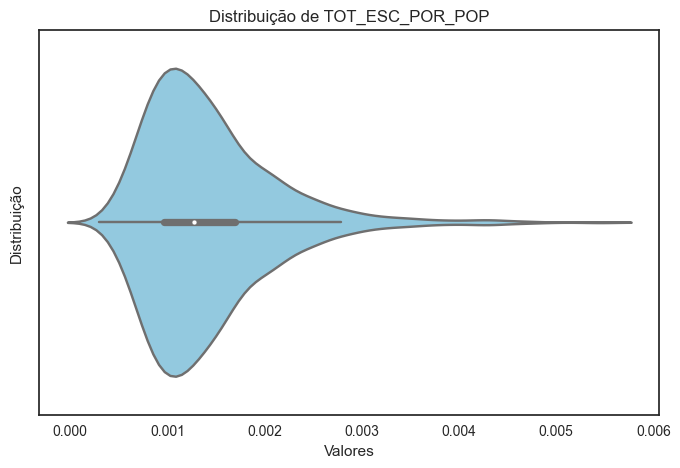

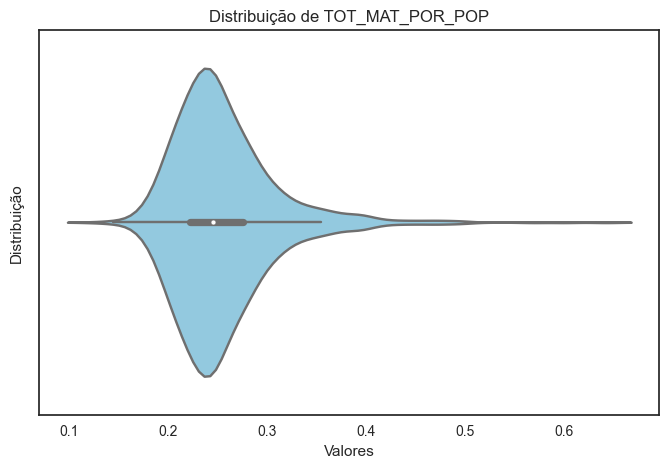

In [3]:
columns = [coluna for coluna in df.columns if (df[coluna].dtype == 'float64')&(coluna not in ['LATITUDE', 'LONGITUDE'])]

for column in columns:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=df[column], color='skyblue')
        
    plt.xlabel('Valores') 
    plt.ylabel('Distribuição')
    plt.title(f'Distribuição de {column}')
    plt.show()

# 3) Redução da dimensinalidade e análise de cluster

## 3.1) Pré-processamento

In [4]:
df_numeric_features = df[columns].copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_features)

## 3.2) Aplicação do PCA

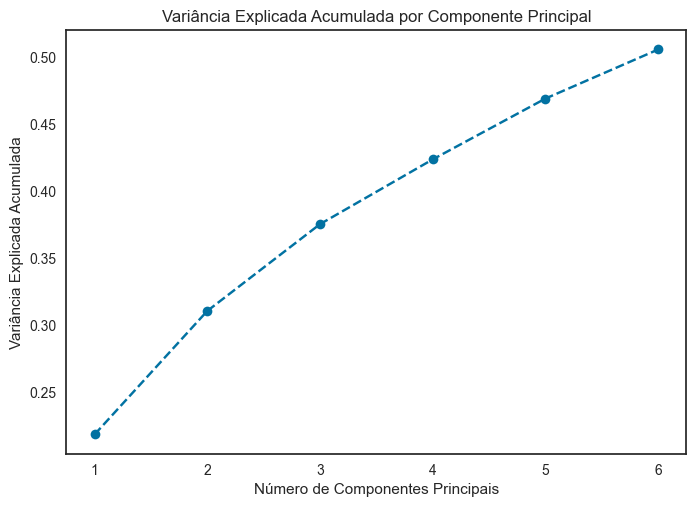

In [5]:
pca = PCA(n_components = 0.50)
df_reducted = pca.fit_transform(df_scaled)

variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.3) Análise de cluster

In [6]:
PCA_plot = PCA(n_components=2, random_state=42)
df_components = PCA_plot.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

def plot(df, df_components, clusters):
    df = pd.concat([df, df_components], axis = 1)
    df['CLUSTER'] = clusters

    actual_cities = df[
        [
            'NOME', 
            'COMPONENT1', 
            'COMPONENT2', 
            'CLUSTER'
        ]
    ].loc[
        df['NOME'].isin(
            [
                'MAURITI', 
                'SAO JOSE DA TAPERA', 
                'BUIQUE', 
                'INAJA'
            ]
        )
    ]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        hue='CLUSTER', 
        s=80,
        #palette=['#999999', '#1d8e42']
    )
    sns.scatterplot(
        data=actual_cities, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        marker = 'X', 
        color='black', 
        s=100, 
        label='Cidades atuais'
    )
    for i, row in actual_cities.iterrows():
        plt.text(row['COMPONENT1'] - 0.5, row['COMPONENT2'] + 0.5, row['NOME'], fontsize=10)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Visualização dos Grupos')
    sns.despine()
    plt.show()

### 3.3.1) Hierarchical Clustering

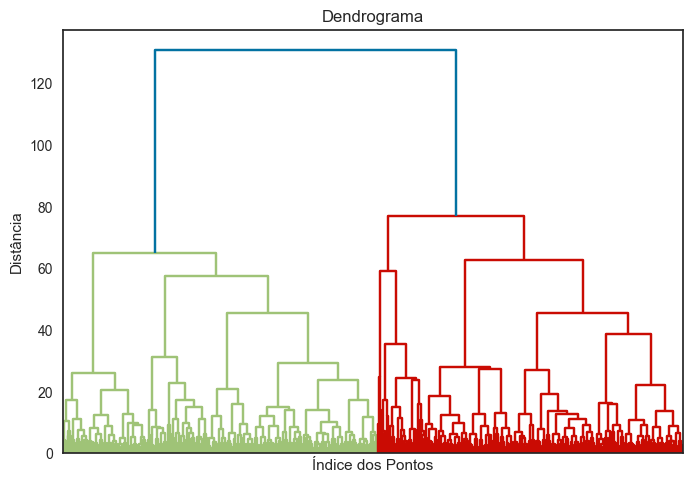

In [7]:
linkage_matrix = linkage(df_reducted, method='ward')

plt.figure()
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xticks([])
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
plt.show()

Silhouette Score:  0.2117
Davies-Bouldin Score:  1.6397
Calinski-Harabasz Index:  387.2912


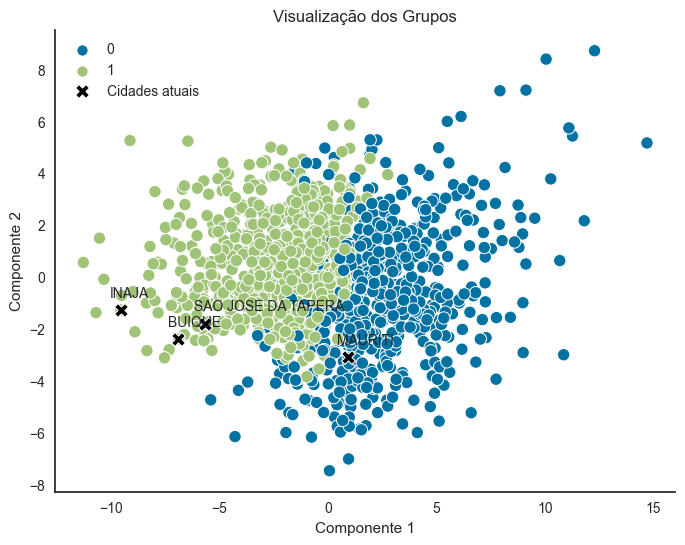

In [8]:
hclustering = AgglomerativeClustering(n_clusters=2)
h_clusters = hclustering.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, h_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, h_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, h_clusters),4))
plot(df, df_components, h_clusters)

### 3.3.2) K-Means

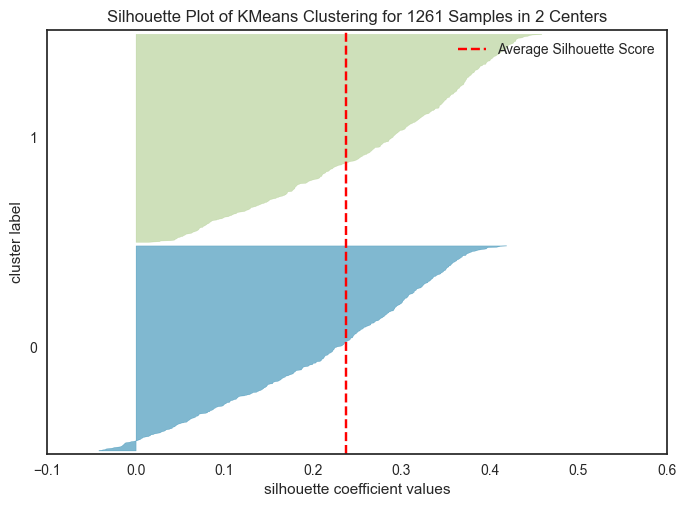

In [9]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reducted)
    score = silhouette_score(df_reducted, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
plt.show()

Silhouette Score:  0.2378
Davies-Bouldin Score:  1.5102
Calinski-Harabasz Index:  458.2511


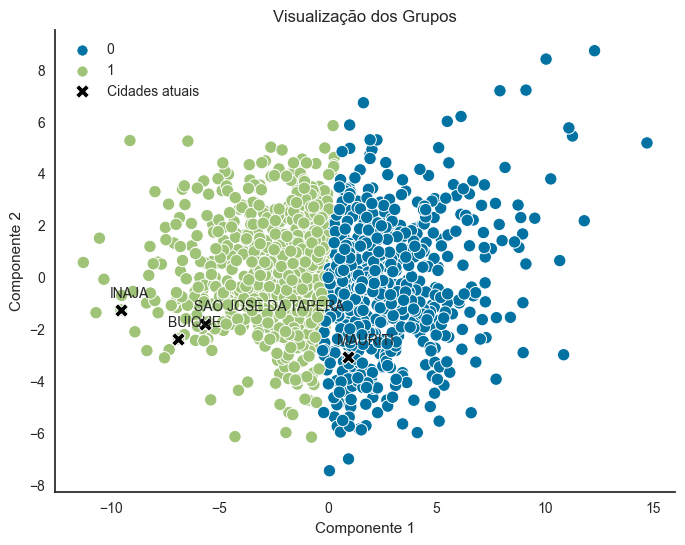

In [10]:
kmeans = KMeans(2, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção das melhores features

In [11]:
X = df[columns]
y = k_clusters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
boruta = BorutaPy(rf_model, n_estimators='auto', verbose=False, random_state=42)
boruta.fit(X_train.values, y_train)
mask_columns_selected = boruta.support_.tolist()
df_pp = X.iloc[:, mask_columns_selected]
columns_selected = df_pp.columns
columns_selected

Index(['DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI', 'IDEB_AF', 'DOCSUP_EF_PUB',
       'DOCSUP_EM_PUB', 'TXNASC7C', 'PDEFAGUA', 'PDEFESGOTO', 'PIND_POS',
       'PMATPUB_EF', 'AGUA_SOLO', 'IDHM', 'T_BANAGUA', 'T_DENS', 'T_LUZ',
       'AGUA_ESGOTO', 'PAREDE', 'PIND', 'PINDCRI', 'I_FREQ_PROP', 'T_FBPRE',
       'T_FBSUPER', 'T_ATRASO_1_BASICO', 'T_ATRASO_1_FUND', 'T_ATRASO_1_MED',
       'T_ATRASO_2_BASICO', 'T_ATRASO_2_FUND', 'T_ATRASO_2_MED',
       'T_ANALF11A14', 'T_ANALF15A17', 'T_ANALF15M', 'T_ANALF18A24',
       'T_ANALF18M', 'T_ANALF25A29', 'T_ANALF25M', 'RDPC', 'TOT_ESC_POR_POP'],
      dtype='object')

## 3.5) Pré-processamento

In [12]:
df_best_features = df[columns_selected].copy()
df_scaled = scaler.fit_transform(df_best_features)

## 3.6) Nova aplicação do PCA

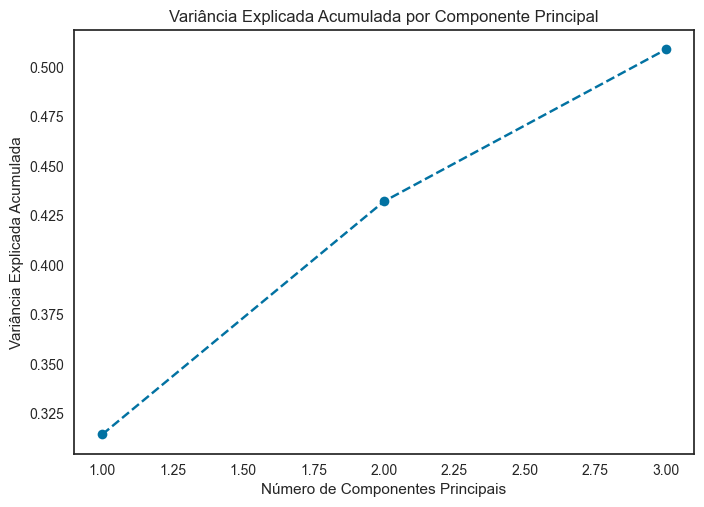

In [13]:
df_reducted = pca.fit_transform(df_scaled)

variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.6) Nova análise de cluster

In [14]:
df_components = PCA_plot.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

### 3.6.1) Hierachical Clustering

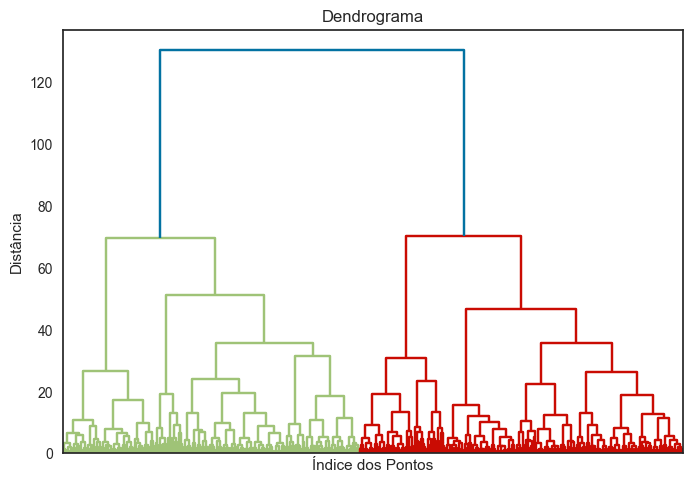

In [15]:
linkage_matrix = linkage(df_reducted, method='ward')

plt.figure()
dendrogram(linkage_matrix)
plt.title('Dendrograma')
plt.xticks([])
plt.xlabel('Índice dos Pontos')
plt.ylabel('Distância')
plt.show()

Silhouette Score:  0.296
Davies-Bouldin Score:  1.2355
Calinski-Harabasz Index:  674.8194


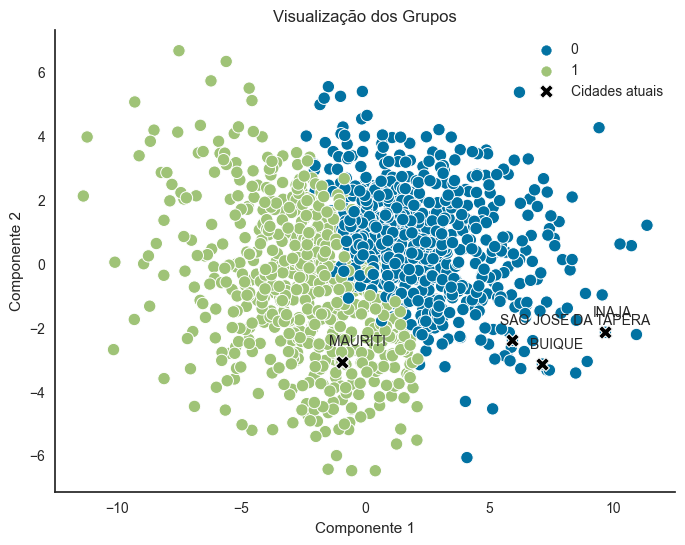

In [16]:
hclustering = AgglomerativeClustering(n_clusters=2)
h_clusters = hclustering.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, h_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, h_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, h_clusters),4))
plot(df, df_components, h_clusters)

### 3.6.2) K-Means

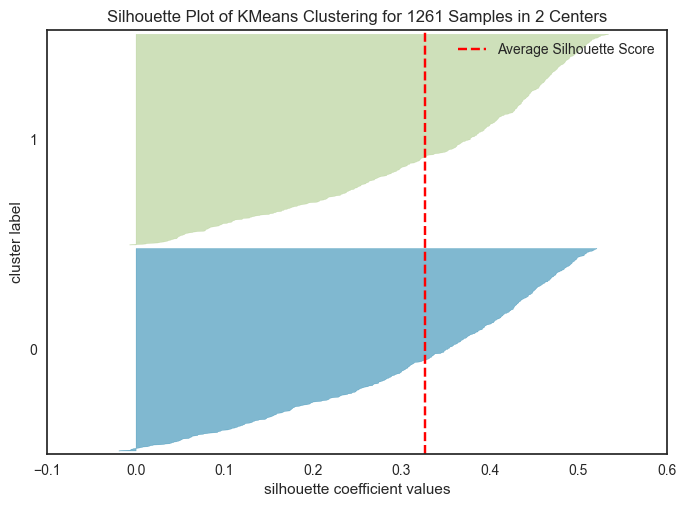

In [17]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reducted)
    score = silhouette_score(df_reducted, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
plt.show()

Silhouette Score:  0.2545
Davies-Bouldin Score:  1.1642
Calinski-Harabasz Index:  598.531


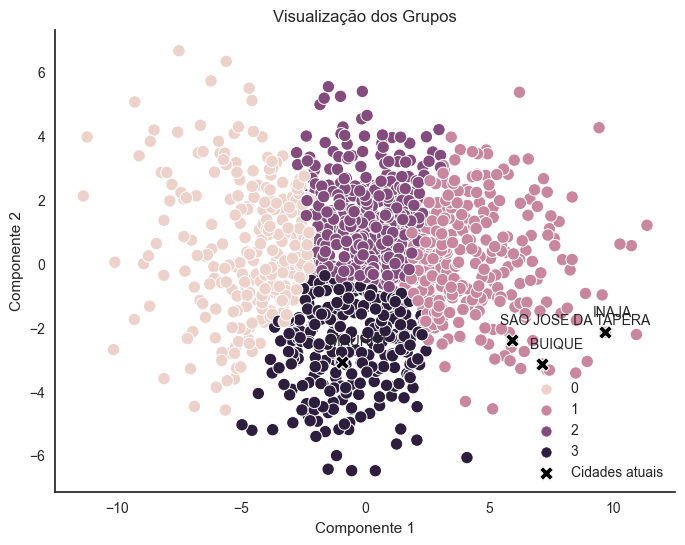

In [18]:
kmeans = KMeans(4, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção dos municípios com maior potencial

In [19]:
df['CLUSTER'] = k_clusters
df.to_csv('../Dados/Tabela_final/municipios_clusters.csv')

### 3.4.1) Interpretação dos municípios atuais

In [20]:
actual_cities = df[
    [
        'NOME', 
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'CLUSTER'
    ]
].loc[df['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA'])]

actual_cities

,NOME,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,CLUSTER
34,SAO JOSE DA TAPERA,0.527,32258.8,225558.2,188.84,37.04,0.536,4.33,39.70,1
418,MAURITI,0.605,46103.4,207315.4,236.11,29.51,0.632,8.31,29.78,3
796,BUIQUE,0.527,56502.4,234399.4,176.76,40.18,0.524,7.25,38.73,1
827,INAJA,0.523,21917.0,89734.8,182.73,35.98,0.471,7.35,41.19,1


### 3.4.1) Filtro e interpretação dos clusters

In [21]:
df = pd.read_csv('../Dados/Tabela_final/municipios_clusters.csv')

df = df.loc[(df['POP_TOT'] >= 21917)&(df['POP_TOT_30KM'] >= 89734)]

df[
    [
        'CLUSTER',
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND'
    ]
].groupby('CLUSTER').mean()

,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND
CLUSTER,,,,,,,,
0,0.658235,97560.827451,313377.531373,417.452451,19.411961,0.663549,8.329314,10.883431
1,0.548475,35384.045000,197770.365000,229.427250,33.828750,0.529675,6.538000,30.923250
2,0.595426,40248.180328,193307.622951,302.511803,25.591803,0.584230,8.318361,18.969180
3,0.605278,40698.314815,207237.329630,253.462222,28.825000,0.659111,6.761481,25.466852


In [22]:
df['CLUSTER'].value_counts()

CLUSTER
0    102
2     61
3     54
1     40
Name: count, dtype: int64

### 3.4.1) Seleção dos municipios de maior potencial

In [23]:
potential_muns = df.copy()

potential_muns = potential_muns[
    [
        'IBGE7',
        'NOME', 
        'UF',
        'IDHM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'IDEB_AI',
        'IDEB_AF',
        'POP_TOT_30KM',
        'POP_TOT'
    ]
].loc[
    (potential_muns['CLUSTER'] == 0)&
    ~(potential_muns['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA']))
].sort_values(by='IDHM').reset_index().drop(columns='index')

potential_muns

,IBGE7,NOME,UF,IDHM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,IDEB_AI,IDEB_AF,POP_TOT_30KM,POP_TOT
0,2918357,JOAO DOURADO,BA,0.593,283.12,20.67,0.637,6.75,16.56,4.440,3.700,187758.6,25149.0
1,2614600,TABIRA,PE,0.605,278.14,23.09,0.623,7.65,18.50,4.984,3.984,156829.4,27952.0
2,2601904,BEZERROS,PE,0.606,351.75,28.12,0.614,9.06,14.75,5.116,4.284,632797.8,60383.6
3,2512309,PRINCESA ISABEL,PB,0.606,334.74,25.33,0.639,6.54,13.22,4.720,3.396,173546.2,22985.2
4,2305308,IBIAPINA,CE,0.608,258.57,25.48,0.661,2.15,15.06,5.392,4.304,269488.4,24645.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2408003,MOSSORO,RN,0.720,600.28,13.80,0.719,10.07,3.72,4.960,3.688,576128.0,288064.0
98,2504009,CAMPINA GRANDE,PB,0.720,630.03,11.68,0.698,10.53,5.02,4.740,3.444,1036090.8,405214.4
99,2903201,BARREIRAS,BA,0.721,602.82,10.33,0.707,8.63,5.52,4.596,3.792,308071.6,154035.8
100,3151206,PIRAPORA,MG,0.731,596.44,7.01,0.730,10.59,2.91,5.852,4.324,140592.8,56217.0


### 3.4.1) Identificação do município mais prioritário

In [24]:
scaler = MinMaxScaler()
best_mun = potential_muns.copy()
for column in ['IDHM','RDPC','I_FREQ_PROP','IDEB_AI','IDEB_AF']:
    best_mun[column] = 1/best_mun[column]
num_metrics = ['IDHM','RDPC', 'T_ANALF15M', 'I_FREQ_PROP', 'T_DES18M','PIND','IDEB_AI','IDEB_AF', 'POP_TOT_30KM','POP_TOT']
best_mun[num_metrics] = scaler.fit_transform(best_mun[num_metrics])
best_mun['SCORE'] = best_mun['RDPC'] + best_mun['PIND'] + best_mun['POP_TOT']
best_mun[num_metrics] = best_mun[num_metrics].rank(ascending=False)
best_mun.sort_values(by='SCORE', ascending= False).reset_index().drop(columns='index')

,IBGE7,NOME,UF,IDHM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,IDEB_AI,IDEB_AF,POP_TOT_30KM,POP_TOT,SCORE
0,2929909,SEABRA,BA,24.0,12.0,79.0,68.5,77.0,2.0,71.0,66.0,82.0,66.0,1.756824
1,2614600,TABIRA,PE,2.0,2.0,24.0,19.0,67.0,8.0,58.0,57.0,68.0,95.0,1.700429
2,2306900,JAGUARIBE,CE,11.5,5.0,8.0,37.0,88.0,3.0,80.5,88.0,100.0,79.0,1.682492
3,2311405,QUIXERAMOBIM,CE,34.5,14.0,17.0,66.0,92.0,4.0,97.0,93.0,70.0,31.0,1.639558
4,2305308,IBIAPINA,CE,5.0,1.0,9.0,53.0,101.0,20.0,76.0,74.0,39.0,98.0,1.629487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2612505,SANTA CRUZ DO CAPIBARIBE,PE,41.5,85.0,80.0,3.5,102.0,99.0,57.0,51.0,24.0,22.0,0.376389
98,2615409,TORITAMA,PE,9.0,75.0,47.0,1.0,100.0,101.0,4.0,9.0,33.0,68.0,0.343239
99,2916401,ITAPETINGA,BA,67.5,84.0,88.0,8.0,71.0,102.0,19.0,26.0,62.0,33.0,0.322344
100,2402006,CAICO,RN,94.0,100.0,86.0,75.0,85.5,98.0,44.0,33.0,66.0,48.0,0.205038


In [25]:
df

,Unnamed: 0,IBGE7,UF,NOME,LATITUDE,LONGITUDE,DIST_EF_PUB,DIST_EM_PUB,IDEB_AI,IDEB_AF,...,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,RDPC,QUAL_MED_AGUA,TRANSPORT_COST,TOT_ESC_POR_POP,TOT_MAT_POR_POP,CLUSTER
0,0,2700300,AL,ARAPIRACA,-9.75487,-36.6615,28.884,43.100,4.580,3.624,...,6.27,24.10,11.76,28.61,423.28,62.268456,24042.166072,0.000433,0.245423,0
7,7,2702355,AL,CRAIBAS,-9.61780,-36.7697,33.400,47.880,4.000,2.916,...,14.06,42.86,25.60,51.21,199.54,62.268456,24157.623963,0.001111,0.304949,1
8,8,2702405,AL,DELMIRO GOUVEIA,-9.38534,-37.9987,33.652,46.980,3.888,3.456,...,7.57,24.97,11.59,29.43,332.13,74.933851,24733.651957,0.000612,0.280835,2
11,11,2702900,AL,GIRAU DO PONCIANO,-9.88404,-36.8316,35.076,48.884,3.980,3.512,...,11.75,39.16,24.20,47.25,177.55,66.862432,24031.204758,0.001673,0.375173,1
12,12,2703106,AL,IGACI,-9.53768,-36.6372,28.940,37.364,3.984,3.176,...,12.66,41.03,25.23,48.04,241.17,62.268456,24155.077136,0.000820,0.212275,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,1253,2805505,SE,POCO VERDE,-10.71510,-38.1813,35.436,45.568,4.392,3.632,...,6.08,32.32,16.29,38.58,266.56,67.735665,24071.604214,0.000796,0.214564,2
1254,1254,2805604,SE,PORTO DA FOLHA,-9.91626,-37.2842,39.748,50.520,3.888,3.280,...,11.23,34.06,18.51,40.36,226.66,65.938444,24177.579577,0.001046,0.254522,1
1255,1255,2805703,SE,PROPRIA,-10.21380,-36.8442,33.396,41.456,3.976,3.044,...,6.34,20.05,9.55,23.54,400.35,66.862432,23852.154609,0.000573,0.253772,0
1258,1258,2807105,SE,SIMAO DIAS,-10.73870,-37.8097,38.340,45.756,4.200,3.364,...,7.36,28.90,14.39,34.16,293.99,63.883423,23918.838452,0.001108,0.254938,2


In [26]:
teste = df.copy()

In [27]:
teste['']

KeyError: ''